# Simulate N-of-1 Trial with 1 Moderator Variable and fit different models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from sinot.simulation import Simulation
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd

import pymc as pm
from dataclasses import dataclass, field
from typing import List
import arviz as az

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

from simulation import Simulation
from treatmentplan import TreatmentPlan


In [3]:
# Define constants
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
from numpy.random import default_rng
rng = default_rng()


## DAG formula

$ O = \mu_p + \epsilon_i + \mathbb{1}(T_i = \text{active}) (\mu_T + \alpha_{T_i} (c - \mu_c))$

- $\mu_p$ - Population baseline mean
- $\epsilon_i$ - Individual baseline mean
- $\mu_T$ - Average Treatment Effect
- $\alpha_{T_i, c}$ - Moderator Slope for Treatment i and c
- $\mu_c$ - Intercept for c 
- $c$ - Value of covariate c

In [183]:
# Simulation constants

treatment_plan = TreatmentPlan(**{'n_observations': 1000, 'treatment_window_length': 10, 'treatment_order': [0,1,2,1,2]})

simulation = Simulation(**{
'mu_p': 1,
'epsilon_i_sigma': 5,
'mu_T': [10, 2],
'alpha': [-1, 1],
'c_sigma': 1,
'treatment_plan': treatment_plan,
})
# c already normalized so we do not cover mu_c

<Axes: >

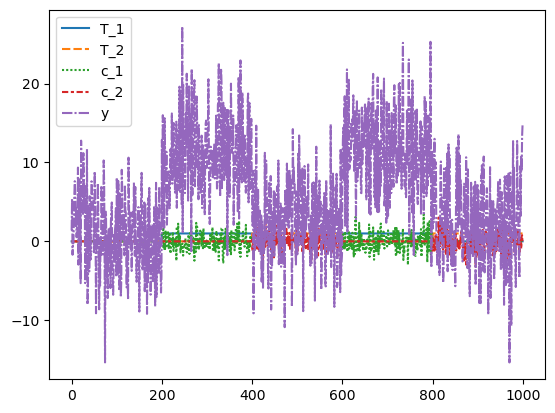

In [84]:
observation = simulation.sample_observation()
sns.lineplot(observation.dataFrame())

# First Model: Linear Regression

In [85]:
X = observation.linear_coefficients()
reg = LinearRegression().fit(X, observation.y)

keys = simulation.true_coefficients().keys()

print(reg.score(X, observation.y))

print(list(zip(keys, reg.coef_)))

print(reg.intercept_)

0.4826185403194998
[('mu_T_1', 10.369770986711007), ('mu_T_2', 1.6553567685665633), ('alpha_T_1', -1.4092989742207194), ('alpha_T_2', 1.019922977275916)]
0.9703128941017445


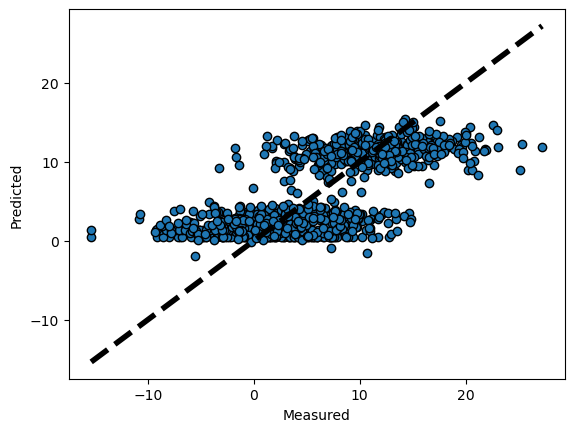

In [86]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(reg, X, observation.y, cv=10)

fig, ax = plt.subplots()
ax.scatter(observation.y, predicted, edgecolors=(0, 0, 0))
ax.plot([observation.y.min(), observation.y.max()], [observation.y.min(), observation.y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


<Axes: xlabel='name', ylabel='value'>

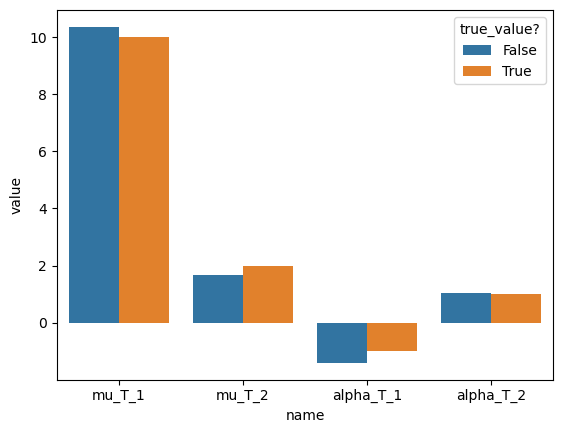

In [87]:
coefficents = pd.DataFrame({'name': simulation.true_coefficients().keys(), 'value': reg.coef_, 'true_value?': False})
true_coefficients = pd.DataFrame({'name': simulation.true_coefficients().keys(), 'value': simulation.true_coefficients().values()})
true_coefficients['true_value?'] = True

sns.barplot(data=pd.concat([coefficents, true_coefficients]), x='name', y='value', hue='true_value?')

# Bayesian Model

In [190]:
model = pm.Model()

with model:
    treatments = observation.treatments
    # Priors for unknown model parameters
    mu_p = pm.Normal("mu_p", mu=0, sigma=100)
    epsilon_i_sigma = pm.HalfNormal("epsilon_i_sigma", sigma=100)
    
    mu_T = pm.Normal("mu_T", mu=0, sigma=100, shape=2)
    
    alpha = pm.Normal("alpha", mu=0, sigma=100, shape=2)
    
    O = pm.Normal("O", mu=(mu_p + ((treatments==1) * (mu_T[0] + alpha[0] * observation.c)) + ((treatments==2) * (mu_T[1] + alpha[1] * observation.c))), sigma=epsilon_i_sigma, observed=observation.y)
    

In [191]:
with model:
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_p, epsilon_i_sigma, mu_T, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


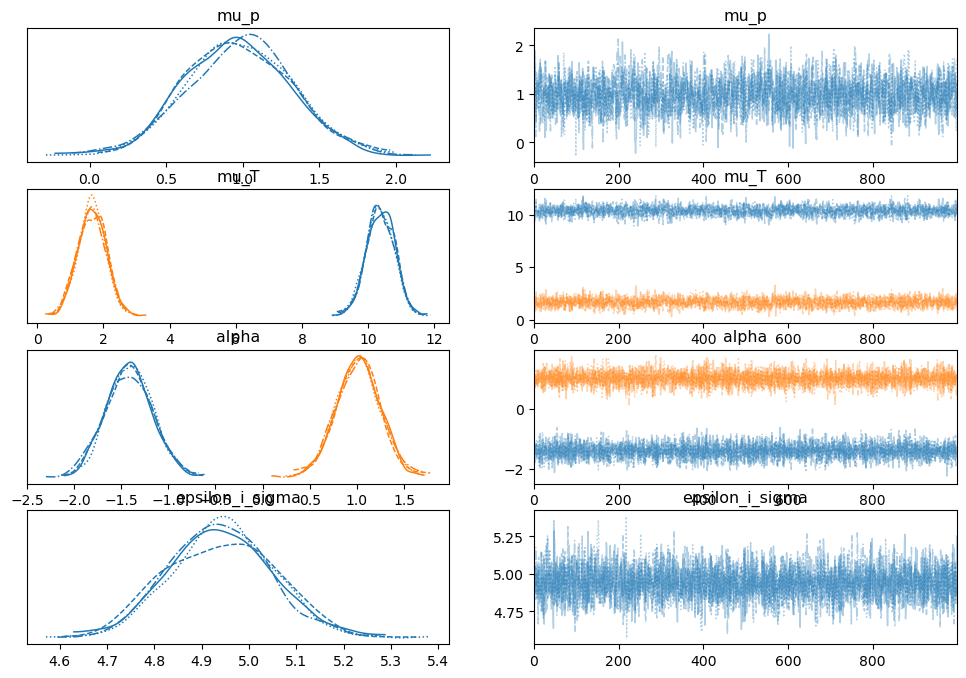

In [192]:
with model:
    az.plot_trace(trace)
    # az.plot_forest(trace)

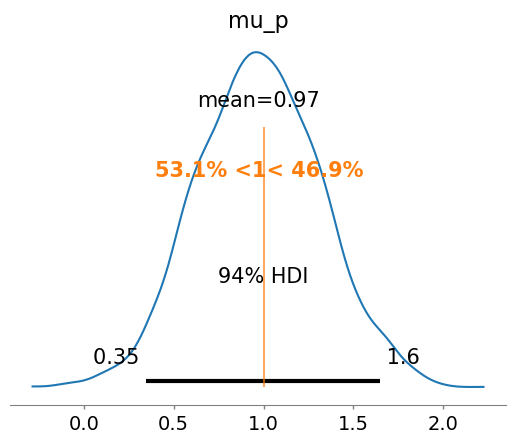

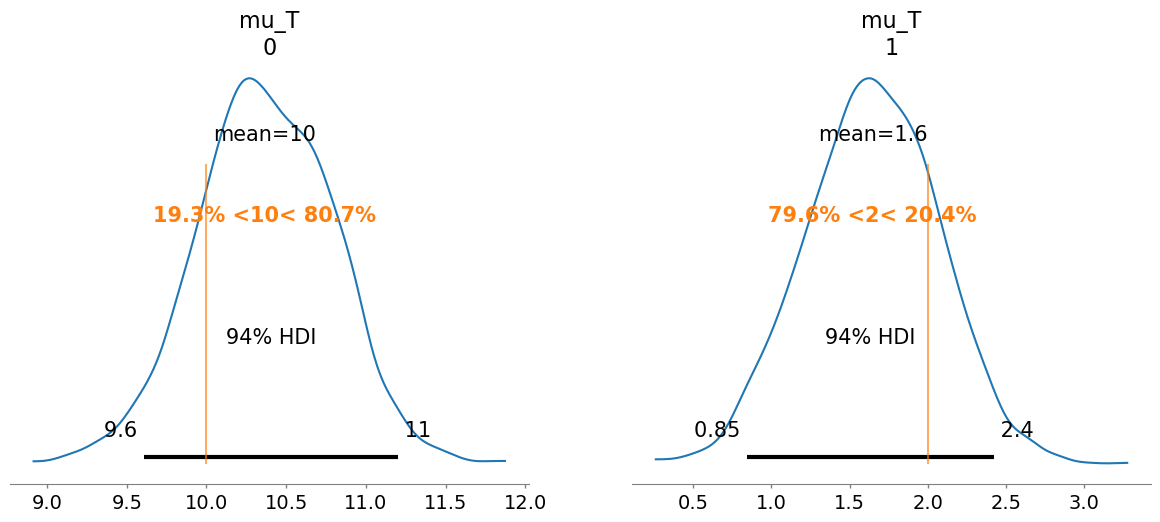

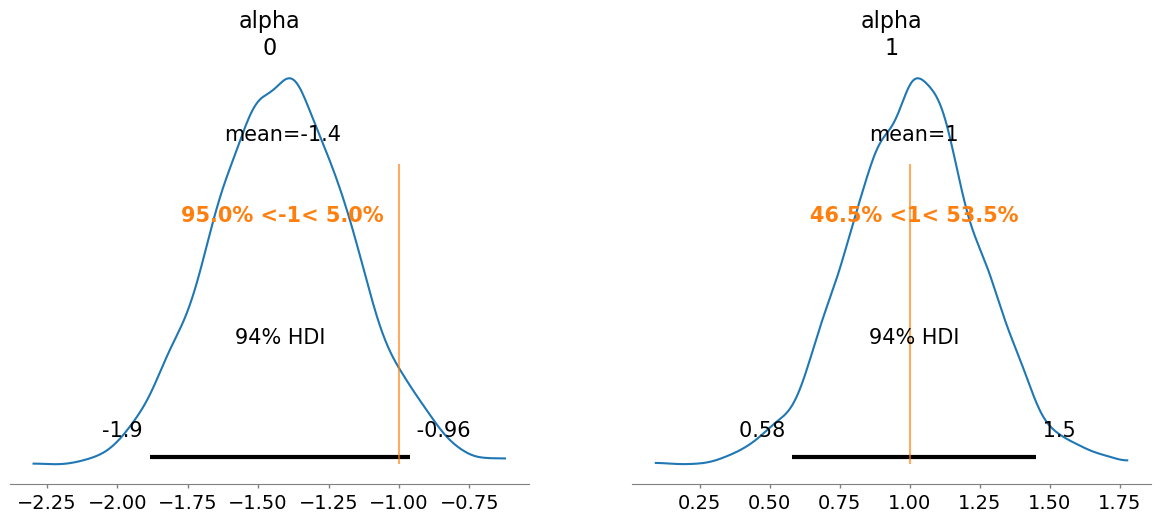

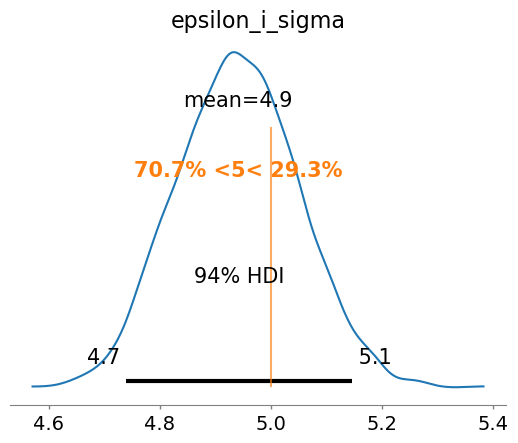

In [193]:
from dataclasses import asdict
with model:
    # az.plot_density(trace)
    # az.plot_violin(trace)
    for variable_name in trace['posterior'].data_vars:
        az.plot_posterior(trace, var_names=[variable_name], ref_val=asdict(simulation)[variable_name]) 